In [34]:
from tqdm.auto import tqdm
import numpy as np
import os, glob, pickle
import pandas as pd
from collections import Counter
import re, string
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import seaborn as sns
from collections import defaultdict, OrderedDict
import utils.score as evaluate

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

import warnings
warnings.simplefilter("ignore")

[nltk_data] Downloading package stopwords to /home/hemant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
!ls data/3a/

data.zip  sentiment_test.csv  sentiment_train.csv


### preprocessing

In [36]:
def remove_punctuation(text): 
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator) 

def prepr(txt):
    dummy = []
    for i in txt.split():
        if '@' in i: dummy.append('@someuser')
        elif '#' in  i: dummy.append('#someuser')
        elif i in stopwords: continue
        else: dummy.append(remove_punctuation(i))
    
    return dummy

### Naive bayes

In [37]:
class naive_bayes_():
    def __init__(self,train, test):
        self.train_x = [prepr(i.lower()) for i in tqdm(train['x'])]
        self.train_y = [i for i in tqdm(train['y'])]
        
        if test:
            self.test_x = [prepr(i.lower()) for i in tqdm(test['x'])]
            self.test_y = [i for i in tqdm(test['y'])]

            self.data_x, self.data_y = self.train_x + self.test_x, self.train_y + self.test_y
        
        else: 
            self.test_x = None
            self.data_x = self.train_x
            self.data_y = self.train_y 
        
        self.vocab = sorted([i for i in set([j for i in tqdm(self.data_x) for j in i])])
        
    def fit(self):
        
        dummy = Counter(self.train_y)
        prior = {i:dummy[i]/len(self.train_y) for i in set(dummy)}
        self.labels = prior.keys()

        matrix = {i:np.zeros(len(self.vocab)) for i in self.labels}
        self.vti = {i:d for d,i in enumerate(self.vocab)}
        
        dummy = {i:len(self.vocab) for i in self.labels}
        for i in tqdm(range(len(self.train_y))):
            count = Counter(self.train_x[i])
            dummy[self.train_y[i]] += sum(count.values())
            
            for k,v in count.items(): 
                matrix[self.train_y[i]][self.vti[k]]+= v
        
        for k,v in matrix.items():
            matrix[k] += 1
            matrix[k]/= dummy[k]
        
        self.prior = prior
        self.matrix = matrix
        self.dummy = dummy
        
        return prior, matrix
        
    def predict(self,test_x,pred=True):
        
        test_x = [' '.join(prepr(i.lower())) for i in test_x]
        pred_y = []

        for i in tqdm(test_x):
            label = {}
            for j in self.labels:
                prob = self.prior[j]
                for w in i.split():
                    if w in self.vti.keys(): prob *= self.matrix[j][self.vti[w]]
                    else: prob *= 1/(len(self.vocab) + self.dummy[j])
                label[j] = prob
#             pred_y.append(label)  
            a = sum(label.values())
            pred_y.append({k:v/a for k,v in label.items()})
        if pred: return [sorted(i.items(), key=lambda x:x[-1], reverse=True)[0][0] for i in pred_y]
        else: return pred_y


.

# 3A

In [38]:
# Dataset loading

train_3a = pd.read_csv('data/3a/sentiment_train.csv') # 11.2 lakhs
test_3a = pd.read_csv('data/3a/sentiment_test.csv') # 4.8 lakhs

dummy = False # Dummy data for testing

if not dummy:
    train = {
                'x': train_3a['5'],
                'y': train_3a['0']
    }

    test = {
                'x': test_3a['5'],
                'y': [i for i in test_3a['0']]
    }

else:
    train = {
                'x': ['chinese beijing chinese', 'chinese chinese shanghai', 'chinese macao','tokyo japan chinese'],
                'y': [1,1,1,2]
    }

    test = {
                'x': ['chinese chinese chinese tokyo japan', 'fuck this shit japan japan tokyo'],
                'y': [1,2]
    }

In [39]:
naive_bayes = naive_bayes_(train,None)
prior, matrix = naive_bayes.fit()

pred = naive_bayes.predict(test['x'], True)
assert len(pred) == len(test['y'])

# Evaluation

In [41]:
metric = evaluate.evaluate(test['y'], pred, naive_bayes.labels)
metric

macro prec and recall -- 0.7682886578859256 0.7681567907714086
 Macro F1 score: 0.7682227186698473
Accuracy: 0.7681166666666667


{'conf_labels': ['0', '4'],
 'conf_matrix': [[186640, 52564], [58740, 182056]],
 'macro_prec_and_rec': [0.7682886578859256, 0.7681567907714086],
 'macro_f1': 0.7682227186698473,
 'accuracy': 0.7681166666666667}

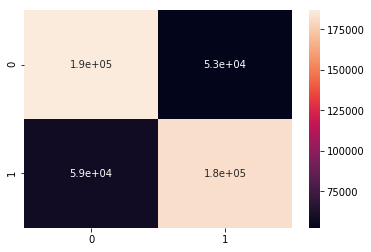

In [42]:
cm = metrics.confusion_matrix(test['y'], pred)
sns.heatmap(cm, annot=True)

# 3B

In [43]:
# Dataset loading

header_list = ['id', 'tweet', 'emo', 'intent']

df_train = pd.read_table('data/3b/train/out.txt', names=header_list)
train_x = [i for i in df_train['tweet']]
train_y = [i for i in df_train['emo']]

df_test = pd.read_table('data/3b/test/out.txt', names=header_list)
test_x = [i for i in df_test['tweet']]
test_y = [i for i in df_test['emo']]

train = {
                'x': train_x,
                'y': train_y
}

test = {
            'x': test_x,
            'y': [i for i in test_y]
}

In [44]:
naive_bayes = naive_bayes_(train,None)
prior, matrix = naive_bayes.fit()

pred = naive_bayes.predict(test['x'], True)
assert len(pred) == len(test['y'])

# Evaluation

In [45]:
metric = evaluate.evaluate(test['y'], pred, naive_bayes.labels)
metric

macro prec and recall -- 0.8145824894713771 0.8134398496240601
 Macro F1 score: 0.8140107685624898
Accuracy: 0.8120759837177748


{'conf_labels': ['joy', 'anger'],
 'conf_matrix': [[612, 102], [175, 585]],
 'macro_prec_and_rec': [0.8145824894713771, 0.8134398496240601],
 'macro_f1': 0.8140107685624898,
 'accuracy': 0.8120759837177748}

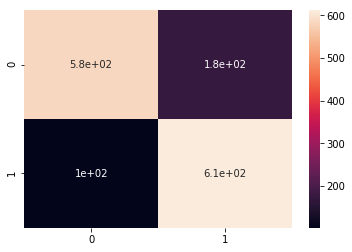

In [46]:
cm = metrics.confusion_matrix(test['y'], pred)
sns.heatmap(cm, annot=True)

## Pearson correlation

In [47]:
pred = naive_bayes.predict(test['x'], False)
pred = [sorted(i.items(), key=lambda x:x[-1], reverse=True)[0] for i in pred]

In [48]:
pred[:3]

[('anger', 0.9961995337682213),
 ('joy', 0.5180680401479583),
 ('anger', 0.99787919080909)]

In [49]:
t_a, p_a = '', ''
for i in range(len(test_x)):
    t_a += f"{i}\t{test_x[i]}\t{df_test['emo'][i]}\t{df_test['intent'][i]}\n"
    p_a += f"{i}\t{test_x[i]}\t{pred[i][0]}\t{pred[i][1]}\n"
#     print(t_a,p_a)
#     break

In [50]:
def save_(path, file):
    with open(path, "w") as f:
        f.write(file)

In [51]:
save_('true.txt', t_a)
save_('pred.txt', p_a)

In [52]:
!python2 eval.py 1 pred.txt true.txt

Pearson correlation between pred.txt and true.txt:	-0.014455233629579792
Spearman correlation between pred.txt and true.txt:	0.017891406897644083
Pearson correlation for gold scores in range 0.5-1 between pred.txt and true.txt:	0.025038320143194705
Spearman correlation for gold scores in range 0.5-1 between pred.txt and true.txt:	0.03419810852157647

Average Pearson correlation:	-0.014455233629579792
Average Spearman correlation:	0.017891406897644083
Average Pearson correlation for gold scores in range 0.5-1:	0.025038320143194705
Average Spearman correlationfor gold scores in range 0.5-1:	0.03419810852157647


.

.

.

# Feature implementation

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


from sklearn.datasets import load_iris

#import IRIS dataset
iris = load_iris()
x = iris.data
y = iris.target
features = iris.feature_names
target = iris.target_names

from sklearn.model_selection import train_test_split

# spliting data in test and train set keeping 70% data in train set and 30% data in test set. 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1)

# Decions tree

In [56]:
# DT Classifier
dt = DecisionTreeClassifier()

# Lets fit the data into classifier 
dt.fit(X_train, y_train)

# predict on test data
y_pred = dt.predict(X_test)
evaluate.evaluate(y_test,y_pred,set(y_test))

macro prec and recall -- 0.9666666666666667 0.9791666666666666
 Macro F1 score: 0.972876516773733
Accuracy: 0.9736842105263158


{'conf_labels': ['0', '1', '2'],
 'conf_matrix': [[13, 0, 0], [0, 15, 1], [0, 0, 9]],
 'macro_prec_and_rec': [0.9666666666666667, 0.9791666666666666],
 'macro_f1': 0.972876516773733,
 'accuracy': 0.9736842105263158}

# sklearn

In [57]:
from sklearn.svm import SVC

# SVC Classifier
clf_SVC = SVC(C=100.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
          probability=False, tol=0.001, cache_size=200, class_weight=None, 
          verbose=0, max_iter=-1, decision_function_shape="ovr", random_state = 0)

# Fitting training data
clf_SVC.fit(X_train,y_train)

# predicting accuracies
print('Accuracy of SVC on training set: {:.2f}'.format(clf_SVC.score(X_train, y_train) * 100))

# predictions
y_pred = clf_SVC.predict(X_test)
print('Test')
evaluate.evaluate(y_test,y_pred,set(y_test))

Accuracy of SVC on training set: 98.21
Test
macro prec and recall -- 0.9666666666666667 0.9791666666666666
 Macro F1 score: 0.972876516773733
Accuracy: 0.9736842105263158


{'conf_labels': ['0', '1', '2'],
 'conf_matrix': [[13, 0, 0], [0, 15, 1], [0, 0, 9]],
 'macro_prec_and_rec': [0.9666666666666667, 0.9791666666666666],
 'macro_f1': 0.972876516773733,
 'accuracy': 0.9736842105263158}

# MLP

In [58]:
from sklearn.neural_network import MLPClassifier # neural network

# Classifier
clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(3, 3), random_state=1, verbose=True, max_iter=20)
# print(clf.get_params())

#Fiting trainging data
clf.fit(X_train, y_train)

#predicting the data
y_pred = clf.predict(X_test)
print('Test')
evaluate.evaluate(y_test,y_pred,set(y_test))

Iteration 1, loss = 1.16374727
Iteration 2, loss = 1.15851323
Iteration 3, loss = 1.15304095
Iteration 4, loss = 1.14749201
Iteration 5, loss = 1.14198799
Iteration 6, loss = 1.13633537
Iteration 7, loss = 1.13055165
Iteration 8, loss = 1.12466765
Iteration 9, loss = 1.11903797
Iteration 10, loss = 1.11342383
Iteration 11, loss = 1.10770560
Iteration 12, loss = 1.10229156
Iteration 13, loss = 1.09693001
Iteration 14, loss = 1.09176170
Iteration 15, loss = 1.08671844
Iteration 16, loss = 1.08199581
Iteration 17, loss = 1.07788282
Iteration 18, loss = 1.07379261
Iteration 19, loss = 1.06977464
Iteration 20, loss = 1.06591248
Test
macro prec and recall -- 0.22875816993464052 0.38425925925925924
 Macro F1 score: 0.2867861197492472
Accuracy: 0.34210526315789475


{'conf_labels': ['0', '1', '2'],
 'conf_matrix': [[0, 9, 4], [0, 6, 10], [0, 2, 7]],
 'macro_prec_and_rec': [0.22875816993464052, 0.38425925925925924],
 'macro_f1': 0.2867861197492472,
 'accuracy': 0.34210526315789475}